## Import data


We will be using the Consumer Price Index (inflation) data for Singapore, which can be found at the following link: https://data.worldbank.org/indicator/FP.inflation.TOTL.ZG?locations=SG. This dataset provides annual percentage changes in the inflation, which is a measure of inflation.


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [63]:
df_CPI = pd.read_csv("../Data-set/CPI_Base2019_Monthly.csv")
df_CPI.info()
df_CPI = df_CPI.head(1)
df_CPI = df_CPI.T
df_CPI = df_CPI.reset_index() # Convert original column names into the first column

df_CPI = df_CPI.iloc[1:].reset_index(drop=True)
df_CPI.rename(columns={"index":"Time", df_CPI.columns[1]:"CPI (base 2019)"}, inplace = True)
df_CPI.head()

# df_CPI.to_csv(os.path.join("../Data-set", "SG_Inflation_Data.csv"), index=False) # index=False → Excludes the default index column from the CSV.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Columns: 769 entries, DataSeries to 1961Jan
dtypes: float64(72), object(697)
memory usage: 913.3+ KB


,Time,CPI (base 2019)
0,2024Dec,117.197
1,2024Nov,116.792
2,2024Oct,116.756
3,2024Sep,117.123
4,2024Aug,116.829


## Data Cleaning
In this step, we filter the dataset to include only the rows where the 'Indicator Name' is "Inflation, consumer prices (annual %)". We then reshape the dataframe using the melt function to transform the year columns into rows, with 'Year' as a variable and 'Inflation Rate' as the value. After that, we select only the 'Year' and 'Inflation Rate' columns and drop any rows with missing values.


In [64]:
df_CPI["Time"] = pd.to_datetime(df_CPI["Time"], format='%Y%b').dt.to_period('M')
df_CPI = df_CPI[df_CPI["Time"].dt.year >= 2000]
df_CPI["CPI (base 2019)"] = df_CPI["CPI (base 2019)"].astype(float)

In [82]:
df_CPI.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 299 to 0
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Time                   300 non-null    period[M]     
 1   CPI (base 2019)        300 non-null    float64       
 2   CPI (base 2024-12)     300 non-null    float64       
 3   inflation_rate (x100)  299 non-null    float64       
 4   Time_dt                300 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), period[M](1)
memory usage: 14.1 KB


## Analysis
Since inflation is stationary, its statistical properties—such as mean and variance—remain stable over time, indicating that past data can reliably inform future expectations. We can use the inflation level to measure and forecast price index across time, using 2024-12 (dataset's latest) as the base year.

In [69]:
cpi_base = df_CPI.loc[df_CPI['Time'] == pd.Period('2024-12', freq='M'), 'CPI (base 2019)'].iloc[0]
df_CPI['CPI (base 2024-12)'] = (df_CPI['CPI (base 2019)'] / cpi_base) * 100


In [73]:
# Compute month-over-month inflation rate
df_CPI = df_CPI.sort_values('Time', ascending=True)
df_CPI['inflation_rate (x100)'] = df_CPI['CPI (base 2024-12)'].astype(float).pct_change() * 100

## Data Cleaning
In this step, we filter the dataset to include only the rows where the 'Indicator Name' is "Inflation, consumer prices (annual %)". We then reshape the dataframe using the melt function to transform the year columns into rows, with 'Year' as a variable and 'Inflation Rate' as the value. After that, we select only the 'Year' and 'Inflation Rate' columns and drop any rows with missing values.


## Exploratory Data Analysis (EDA)

The dataset contains annual inflation rates for Singapore. We analyze inflation trends over time, check for stationarity, and visualize the data distribution.




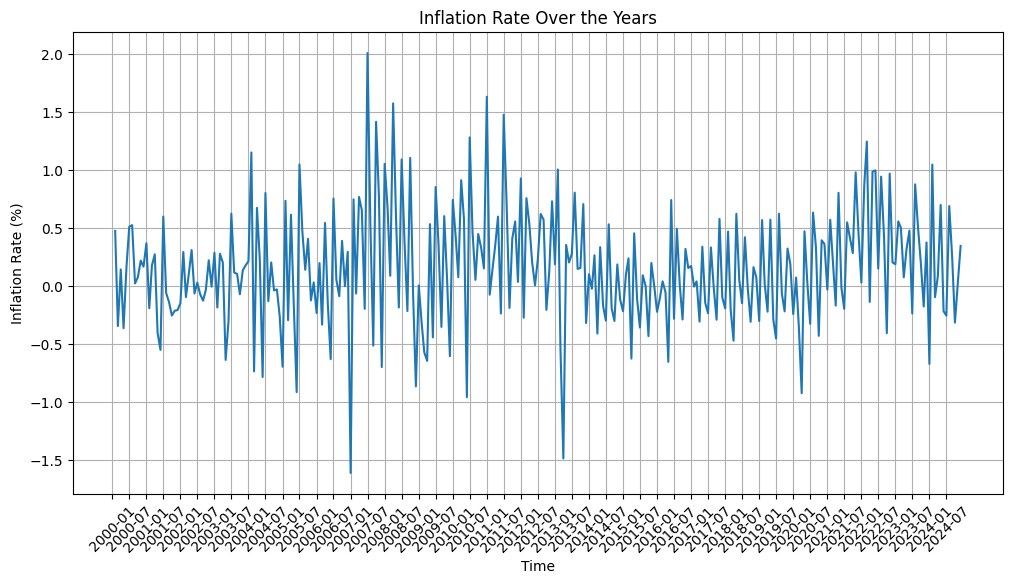

In [81]:
# Inflation Rate over the years

df_CPI["Time_dt"] = df_CPI["Time"].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_CPI, x="Time_dt", y="inflation_rate (x100)")
plt.xticks(df_CPI["Time_dt"][::6], df_CPI["Time_dt"][::6].dt.strftime('%Y-%m'), rotation=45)
plt.title("Inflation Rate Over the Years")
plt.xlabel("Time")
plt.ylabel("Inflation Rate (%)")
plt.grid(True)
plt.show()


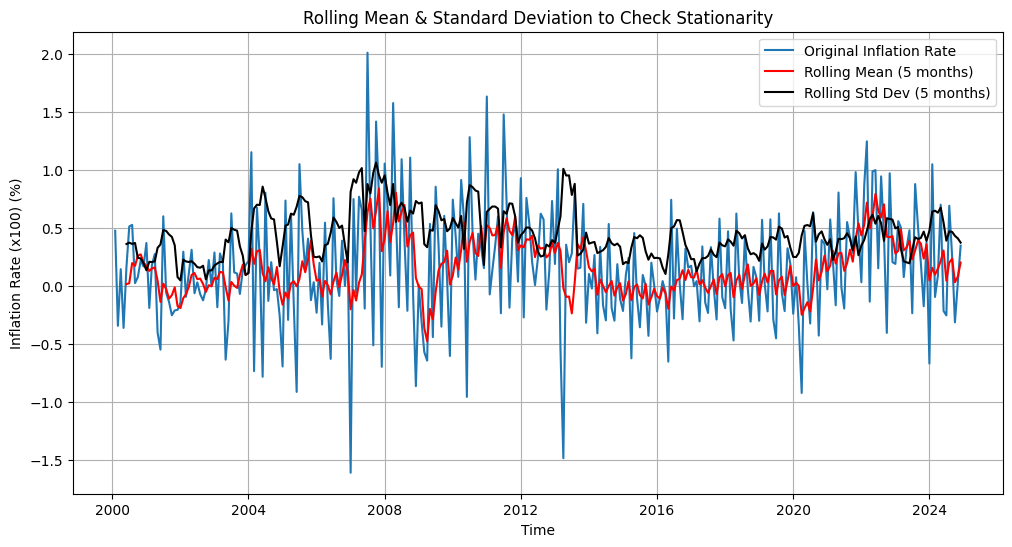

ADF Test Statistic: -3.001341454055509
p-value: 0.03476931510977747
Critical Values: {'1%': -3.453342167806272, '5%': -2.871663828287282, '10%': -2.572164381381345}
The data is stationary


In [84]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the correct column name and reference the correct dataframe
rolling_mean = df_CPI["inflation_rate (x100)"].rolling(window=5).mean()
rolling_std = df_CPI["inflation_rate (x100)"].rolling(window=5).std()

# Plot the statistics
plt.figure(figsize=(12, 6))
plt.plot(df_CPI["Time_dt"], df_CPI["inflation_rate (x100)"], label="Original Inflation Rate")
plt.plot(df_CPI["Time_dt"], rolling_mean, color="red", label="Rolling Mean (5 months)")
plt.plot(df_CPI["Time_dt"], rolling_std, color="black", label="Rolling Std Dev (5 months)")
plt.legend()
plt.title("Rolling Mean & Standard Deviation to Check Stationarity")
plt.xlabel("Time")
plt.ylabel("Inflation Rate (x100) (%)")
plt.grid(True)
plt.show()

# ADF Test
result = adfuller(df_CPI["inflation_rate (x100)"].dropna())
print("ADF Test Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

if result[1] < 0.05:
    print("The data is stationary")
else:
    print("The data is non-stationary")

In [87]:
df_CPI = df_CPI[["Time", "CPI (base 2024-12)", "inflation_rate (x100)"]]
df_CPI.info()
df_CPI.to_csv('../Clean-data/SG_Inflation_Data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 299 to 0
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype    
---  ------                 --------------  -----    
 0   Time                   300 non-null    period[M]
 1   CPI (base 2024-12)     300 non-null    float64  
 2   inflation_rate (x100)  299 non-null    float64  
dtypes: float64(2), period[M](1)
memory usage: 9.4 KB
